# Maximum Entropy Approximation - Joint distribution  P(m, p)

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import os
import glob
import dill
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy

# Import library to perform maximum entropy fits
from maxentropy.skmaxent import FeatureTransformer, MinDivergenceModel
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/MaxEnt_approx_joint/'
datadir = '../../data/csv_maxEnt_dist/'

### $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{avg}[1]{\left\langle #1 \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{ll}[1]{\underset{\sim}{#1}}$
---

# The joint distribution $P(m, p)$ using MaxEnt.

So far we used the MaxEnt approach to approximate the marginal distributions for mRNA $P(m)$ and protein $P(p)$. In reality since the protein copy number depends on the mRNA count we have a joint distribution $P(m, p)$. By definition the marginals we have computed are of the form
$$
P(m) \equiv \sum_p P(m, p),
\tag{1}
$$
and
$$
P(p) \equiv \sum_m P(m, p),
\tag{2}
$$

This joint distribution could contain relevant information that we lose when performing these marginalizations. Therefore in this notebook we will use the exact same MaxEnt approach as before to compute the joint distribution.

For the case of the joing distribution we have moments for the mRNA marginal distribution
$$
\ee{m^i} \equiv \sum_m \sum_p m^i P(m, p),
\tag{3}
$$
and equivalent moments for the protein distribution
$$
\ee{p^i} \equiv \sum_m \sum_p p^i P(m, p).
\tag{4}
$$

We also know the steady-state value of cross-correlations of the form
$$
\ee{m^i p^j} \equiv \sum_m \sum_p m^i p^j P(m, p), 
\tag{5}
$$
where $i, j \in \{1, 2\}$.

Using these moments we can follow the exact same strategy to compute the MaxEnt approximation of the joint distribution.

That means that our MaxEnt approximate joint distribution $P_H(m, p)$ is of the form
$$
P_H(m, p) = {1 \over \mathcal{Z}} \exp \left[
\sum_{i=1}^3\lambda_i^{(m)} m^i +
\sum_{j=1}^3\lambda_j^{(p)} p^j +
\sum_{i,j \in \{1, 2\}}\lambda_{ij}^{(mp)} m^i p^j
\right],
\tag{6}
$$
where all the $\lambda$ terms represent the Lagrange multipliers that need to be numerically determined.

Given this form of the distribution the MaxEnt moments $\ee{m^ip^j}_H$ are given by
$$
\ee{m^ip^j}_H \equiv \sum_m \sum_p m^ip^j P_H(m, p).
\tag{7}
$$

Let's now look into how to obtain the value of the Lagrange multipliers.

## The Newton-Raphson algorithm

Following [Smadbeck & Kaznessis, 2013](http://www.pnas.org/content/110/35/14261) we will use a Newton-Raphson algorithm to get at the value of these Lagrange multipliers.

Let $\ll{\lambda}$ be an array containing all Lagrange multipliers, and $\ll{\mu_H}$ be the estimate of all the MaxEnt moments computed using $P_H(m, p)$. The steps listed by the authors go as follows:

1. Initialize Lagrange multipliers $\ll{\lambda} = \ll{\lambda_0}$ (Typically a guess of all zeros works).
2. Calculate the joint distribution $P_H(m, p)$ as determined by Eq. 6.
3. Calculate the moments used for the constraints $\ll{\mu_H}$ with Eq. 7.
4. Calculate the difference between the **known** moments and the MaxEnt estimates as
$$
\Delta\ll{\mu} = \ll{\mu} - \ll{\mu_H}.
\tag{8}
$$
5. Calculate the 2-norm error with
$$
\varepsilon = \ll{\mu_H}^T \ll{\mu_H}
\tag{9}
$$
6. If $\varepsilon \leq$ `tol` (i.e. a user determined tolerance value) proceed to the last step 7. Otherwise

    a. Calculate the Jacobian Matrix $\bb{J}$ with entries
    $$
    J_{i,j} \equiv {\partial \mu_{H,i} \over \partial \lambda_j}.
    \tag{10}
    $$
    (We'll come back to how to compute this matrix)
    b. The Newton-Raphson method uses a first-order Taylor expansion of the form
    $$
    \Delta\ll{\mu} \approx \bb{J} \Delta \ll{\lambda}.
    \tag{11}
    $$
    Therefore we can estimate the step size for each of our Lagrange multipliers
    as
    $$
    \Delta \ll{\lambda} \approx \bb{J}^{-1} \Delta\ll{\mu}
    \tag{12}
    $$
    c. Using this approximation we update our estimates for the i$^{\text{th}}$
    iteration as
    $$
    \ll{\lambda}^{(i + 1)} = \ll{\lambda}^{(i)} + \Delta \ll{\lambda}
    \tag{13}
    $$
    d. Repeat from step 2.
7. Once the $\varepsilon \leq$ `tol` relationship is satisfied return the Lagrange multipliers values $\ll{\lambda}$

## Jacobian Matrix $\bb{J}$

To compute the derivative from Eq. 10 we need to be very careful with the indexing. First we will rewrite the MaxEnt distribution (Eq. 6) as
$$
P_H(m, p) = {1 \over \mathcal{Z}} \exp \left[
- \sum_{i=1}^N \lambda_i m^{x_i} p^{y_i},
\right],
\tag{14}
$$
where we index all Lagrange multipliers $\lambda_i$ to be associated with each of the constraints of the form $\ee{m^{x_i} p^{y_i}}$. In our specific case we have the Lagrange multipliers of the form:
$$
\left\{
\lambda_1 : \ee{m},
\lambda_2 : \ee{m^2},
\lambda_3 : \ee{m^3},\\
\lambda_4 : \ee{p},
\lambda_5 : \ee{p^2},
\lambda_6 : \ee{p^3},\\
\lambda_7 : \ee{mp},
\lambda_8 : \ee{m^2p},
\lambda_9 : \ee{mp^2}
\right\}
\tag{15}
$$

This implies that Eq. 10 is given by
$$
J_{i,j} = {\partial \over \partial \lambda_j} \ee{m^{x_i} p^{y_j}}_H.
\tag{16}
$$
Combining Eq. 7 and Eq. 14 gives
$$
J_{i,j} = {\partial \over \partial \lambda_j}\left(
\sum_m \sum_p m^{x_i} p^{y_i}
{1 \over \mathcal{Z}} \exp \left[
- \sum_{k=1}^N \lambda_k m^{x_k} p^{y_k},
\right]
\right).
\tag{17}
$$
Evaluating this derivative gives
$$
J_{i,j} = \sum_m \sum_p \left( m^{x_i} p^{y_i} \right)
\left( - m^{x_j} p^{y_j}  \right)
{1 \over \mathcal{Z}} \exp \left[
- \sum_{k=1}^N \lambda_k m^{x_k} p^{y_k}
\right].
\tag{18}
$$
This is simplified to
$$
J_{i,j} = - \ee{m^{x_i + x_j} p ^{y_i + y_j}}_H
\tag{19}
$$

### Implementing the algorithm.

In the following steps we will be implementing such algorithm

The first thing we will define is a function to compute the "product space" $m^x p^y$ for a given selection of $m$ andp $p$ values. These products will be fed to the algorithm as a pre-computed entry.

We will also define the "logsum space" defined as $x\cdot \ln m + y\cdot \ln p$ for a given selection of $m$ and $p$ values. This will be useful when computing log probabilities and log moments.

In [2]:
def product_space(mRNA, protein, exponents=[0, 0]):
    '''
    Computes all the products of the form m**x * p**y for all possible pairs
    of m and p given in the mRNA and protein arrays.
    Parameters
    ----------
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    exponents : array-like. 2x1
        Exponents for the product.
        exponents[0] = mRNA exponent x
        exponents[1] = mRNA exponent y
    Returns
    -------
    prod_space : array-like. len(mRNA) x len(protein).
        All possible pairwise products.
        rows = mRNA
        columns = protein
    '''
    # Build mRNA and protein grid
    mm, pp = np.meshgrid(mRNA, protein)
    
    # Compute product and return all possible pairwise products
    return (mm**exponents[0] * pp**exponents[1]).T


def logsum_space(mRNA, protein, exponents=[0, 0]):
    '''
    Computes all the sums of the form x * ln(m) + y * ln(p) for 
    all possible pairs of m and p given in the mRNA and protein arrays.
    Parameters
    ----------
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    exponents : array-like. 2x1
        Exponents for the product.
        exponents[0] = mRNA exponent x
        exponents[1] = mRNA exponent y
    Returns
    -------
    sum_space : array-like. len(mRNA) x len(protein).
        All possible pairwise sums.
        rows = mRNA
        columns = protein
    '''
    # Convert to decimal points
    mRNA = mRNA.astype('float')
    protein = protein.astype('float')
    
    # Check for zeros and change it to numerical precision
    mRNA[mRNA == 0] = 1E-323
    protein[protein == 0] = 1E-323
    
    # Build log mRNA and log protein grid
    logmm, logpp = np.meshgrid(np.log(mRNA), np.log(protein))
    
    # Compute product and return all possible pairwise products
    return (exponents[0] * logmm + exponents[1] * logpp).T

Having this in hand let's define a function that takes an array of Lagrange multipliers `lambda_array` and a 3D array `products` of pre-computed products products and returns the **MaxEnt** probability distribution for each entry $(m, p)$

In [3]:
def MaxEnt_joint_dist(lambda_array, products, log=False):
    '''
    Computs the MaxEnt probability distribution given constraints captured
    by the Lagrange multipliers in the lambda_array list and all the products
    associated with each of the Lagrange multipliers
    Parameters
    ----------
    lambda_array : array-like. 1 x N.
        List of Lagrange multipliers to be used to compute the MaxEnt
        distribution.
        N = Number of constraints
    product : ndarray. mRNA x protein x N
        3D array with matrices containing the products associated with each
        of the Lagrange multipliers.
    log : bool. Default = False
        Boolean indicating if the Log probability should be returned instead
        For this the function usies scipy.misc.logsumexp to perform the 
        summation
    Returns
    -------
    MaxEnt_dist: array-like. len(mRNA) x len(protein)
        Maximum entropy distribution for each pairwise m,p entry
    '''
    # Confirm that the number of constraints is the same as the number of 
    # associated products
    if len(lambda_array) != products.shape[0]:
        raise ValueError('The number of constraints must be the same as '+\
                         'the number of given products')
    
    # Compute ∑ lambda_i m**x_i * p**y_i
    lambdas_mp = - np.sum(products * \
                   np.array(lambda_array)[:, np.newaxis, np.newaxis],
                          axis=0)
    # Compute logZ
    logZ = scipy.special.logsumexp(lambdas_mp)
    
    # Check if the log probability or the probability were requested
    if log:
        return lambdas_mp - logZ
    else:
        return np.exp(lambdas_mp) / np.exp(logZ)


Now we need a function that computes the moment $\ee{m^x p^y}_H$ as defined in Eq. 7 **given a pre-computed** maximum entropy distribution $P_H(m, y)$.

In [4]:
def MaxEnt_joint_moment(mRNA, protein, dist, exponents, log=False):
    '''
    Computes the moment <m**x * p**y> (or log moment) given a pre-computed 
    distribution dist and sample space mRNA and protein.
    Parameters
    ----------
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    dist : array-like. len(mRNA) x len(protein)
        Joint distribution of protein and mRNA.
    exponents : array-like. 2x1
        Exponents for the product.
        exponents[0] = mRNA exponent x
        exponents[1] = mRNA exponent y
    log : bool. Default = False.
        Boolean indicating if log(<m**x * p**y>) should be computed.
        NOTE: If True dist is assumed to be the log probability!
    Returns
    -------
    The moment (or log moment)
    '''
    # Check that the distribution is the same size as the sample space
    if (len(mRNA) != dist.shape[0]) or (len(protein) != dist.shape[1]):
        raise ValueError('The sample space and the distribution have' +\
                        'different sizes.')
    
    # Check if the log moment was requested
    if log:
        # Compute the log moment as the 
        # log(sum(exp(x ln m + y ln p + logP)))
        return scipy.special.logsumexp(logsum_space(mRNA, protein, exponents)\
                                      + dist + 1E-323)
    else:
        # Perform product and multiply by probability distribution
        return np.sum(product_space(mRNA, protein, exponents) * dist)

---
### Computing the linear residuals for minimization.

Having defined these functions let's define a function that computes the residuals between the expectd moments and the MaxEnt moments along with a function that computes the Jacobian and Hessian matrix.

In [5]:
def MaxEnt_resid(param, constraints, products):
    '''
    Computes the residual between the expected moments and the MaxEnt
    approximate moments. This function will be used by the minimization
    procedure to obtain the value of the Lagrante multipliers.
    Parameters
    ----------
    param : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    constraints : array-like.
        Value of the expected moments of the form <m**x * p**y>
        corresponding to each of the Lagrange multipliers.
    products : ndarray. len(constraints) x len(mRNA) x len(protein)
        Array containing the pre-computed products of the form
        m**x * p**y associated with each of the constraints.
    Returns
    -------
    Difference between expected moments and MaxEnt moments
    '''
    # Compute probability distribution
    Pmp = MaxEnt_joint_dist(param, products)

    # Calculate moments associated with constraints
    maxent_moments = np.array([np.sum(x * Pmp) for x in products])

    # Compute the ∆moments
    return constraints - maxent_moments


def MaxEnt_jacobian(param, constraints, products,
                    mRNA, protein, exponents):
    '''
    Computes the Jacobian matrix in which each entry is the derivative
    of the moment <m**x_i * p**y_i> with respect to the jth lagrange
    multiplier. This results in
    d <m**x_i * p**y_i> / d lambda_j =  - <m**(x_i + x_j) * p**(y_i + y_j)>
    Parameters
    ----------
    param : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    constraints : array-like.
        Value of the expected moments of the form <m**x * p**y>
        corresponding to each of the Lagrange multipliers.
    products : PLACEHOLDER
        Dummy variable necessary to be included for the scipy funciton to
        work. This function DOES NOT use the pre-computed products since 
        the moments to be calculated depend on the derivative been taken.
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    exponents : array-like. 2x1
        Exponents for the product.
        exponents[0] = mRNA exponent x
        exponents[1] = mRNA exponent y
    Returns
    -------
    Jacobian matrix
    '''
    # Compute probability distribution
    Pmp = MaxEnt_joint_dist(param, products)
    
    # Initialize matrix
    Jacobian = np.zeros([len(exponents), len(exponents)])
    # Loop through exponents computing each entry of the matrix
    for i, expi in enumerate(exponents):
        for j, expj in enumerate(exponents):
            Jacobian[i, j] = - MaxEnt_joint_moment(mRNA, protein, Pmp, 
                               np.array(expi) + np.array(expj))

    return Jacobian


def MaxEnt_hessian(param, constraints, products,
                    mRNA, protein, exponents):
    '''
    Computes the Hessian matrix in which each entry is the second
    derivative of the moment <m**x_i * p**y_i> with respect to 
    the ith and the jth lagrange multiplier. This results in
    d**2 <m**x_i * p**y_i> / d lambda_i d lambda_j=  \
    <m**(2 * x_i + x_j) * p**(2 * y_i + y_j)>
    Parameters
    ----------
    param : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    constraints : array-like.
        Value of the expected moments of the form <m**x * p**y>
        corresponding to each of the Lagrange multipliers.
    products : PLACEHOLDER
        Dummy variable necessary to be included for the scipy funciton to
        work. This function DOES NOT use the pre-computed products since 
        the moments to be calculated depend on the derivative been taken.
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    exponents : array-like. 2x1
        Exponents for the product.
        exponents[0] = mRNA exponent x
        exponents[1] = mRNA exponent y
    Returns
    -------
    Hessian matrix
    '''
    # Compute probability distribution
    Pmp = MaxEnt_joint_dist(param, products)
    
    # Initialize matrix
    Hessian = np.zeros([len(exponents), len(exponents)])
    # Loop through exponents computing each entry of the matrix
    for i, expi in enumerate(exponents):
        for j, expj in enumerate(exponents):
            Hessian[i, j] = MaxEnt_joint_moment(mRNA, protein, Pmp, 
                               2 * np.array(expi) + np.array(expj))

    return Hessian

---
### Computing the log residuals for minimization.

As an alternative approach that can be numerically more stable we will now define functions to compute the difference between the log expected moment and the log MaxEnt moment.

The log expected moment is simply computed numerically by taking the log of the value that we want the MaxEnt to be satisfied $\ln \ee{m^x p^y}$.

The log of the MaxEnt moment is computed using the `scipy.special.logsumexp` function that is more stable when performing sums of the form $\log \sum_x e^x$. We have that the log joint probability distribution is of the form
$$
\log P(m, p) = - \sum_{i=1}^N \left[\lambda_i m^{x_i} p^{y_i}\right] -
\log \mathcal{Z}.
\tag{20}
$$
So computing the log of a moment using the log probability distribution can be done as
$$
\log \ee{m^x p^y}_H = \log \sum_{i=1}^N \left[ m^x p^y 
\exp\left(\log P(m, x)\right) \right],
\tag{21}
$$
which can be rewritten as
$$
\log \ee{m^x p^y}_H = \log \sum_{i=1}^N \exp \left[ x \log m + y \log p +
\log P(m, x) \right].
\tag{22}
$$
So with this in hand we will implement a function to compute the residuals $\ln \ee{m^x p^y} - \ln \ee{m^x p^y}_H$

In [11]:
def MaxEnt_log_resid(param, constraints, products, logsums):
    '''
    Computes the residual between the log expected moments and the MaxEnt
    approximate log moments. This function will be used by the minimization
    procedure to obtain the value of the Lagrante multipliers.
    Parameters
    ----------
    param : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    constraints : array-like.
        Value of the expected moments of the form <m**x * p**y>
        corresponding to each of the Lagrange multipliers.
    products : ndarray. len(constraints) x len(mRNA) x len(protein)
        Array containing the pre-computed products of the form
        m**x * p**y associated with each of the constraints.
    logsums : ndarray. len(constraints) x len(mRNA) x len(protein)
        Array containing the pre-computed sums of the form
        x * log(m) + y * log(p) associated with each of the constraints.   
    Returns
    -------
    Difference between log expected moments and MaxEnt log moments
    '''
    # Compute probability distribution
    logPmp = MaxEnt_joint_dist(param, products, log=True)

    # Calculate moments associated with constraints
    logmaxent_moments = np.array([scipy.special.logsumexp(x + logPmp)\
                               for x in logsums])

    # Compute the ∆moments
    return constraints - logmaxent_moments


def MaxEnt_log_jacobian(param, constraints, products, logsums,
                        mRNA, protein, exponents):
    '''
    Computes the Jacobian matrix in which each entry is the derivative
    of the moment <m**x_i * p**y_i> with respect to the jth lagrange
    multiplier. This results in
    d log<m**x_i * p**y_i> / d lambda_j =\
    - <m**(x_i + x_j) * p**(y_i + y_j)> / <m**x_i * p**y_i>
    Parameters
    ----------
    param : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    constraints : array-like.
        Value of the expected moments of the form <m**x * p**y>
        corresponding to each of the Lagrange multipliers.
    products : ndarray. len(constraints) x len(mRNA) x len(protein)
        Array containing the pre-computed products of the form
        m**x * p**y associated with each of the constraints.
    logsums : ndarray. len(constraints) x len(mRNA) x len(protein)
        Array containing the pre-computed sums of the form
        x * log(m) + y * log(p) associated with each of the constraints. 
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    exponents : array-like. 2x1
        Exponents for the product.
        exponents[0] = mRNA exponent x
        exponents[1] = mRNA exponent y
    Returns
    -------
    Jacobian matrix
    '''
    # Compute probability distribution
    Pmp = MaxEnt_joint_dist(param, products)
    
    # Initialize matrix
    Jacobian = np.zeros([len(exponents), len(exponents)])
    # Loop through exponents computing each entry of the matrix
    for i, expi in enumerate(exponents):
        for j, expj in enumerate(exponents):
            Jacobian[i, j] = - MaxEnt_joint_moment(mRNA, protein, Pmp, 
                               np.array(expi) + np.array(expj)) /\
                            MaxEnt_joint_moment(mRNA, protein, Pmp, 
                               np.array(expi))

    return Jacobian

In [12]:
# Extract moments
mRNA_mean = mRNA_moments[0]
mRNA_std = np.sqrt(mRNA_moments[1] - mRNA_mean**2)
protein_mean = protein_moments[0]
protein_std = np.sqrt(protein_moments[1] - protein_mean**2)

# Compute range
std_factor = 5
mRNA_range = [int(x) for x in [mRNA_mean - std_factor * mRNA_std,
              mRNA_mean + std_factor * mRNA_std]]
protein_range = [int(x) for x in [protein_mean - std_factor * protein_std,
                 protein_mean + std_factor * protein_std]]

# Define sample space
mRNA_space = np.arange(*mRNA_range)
protein_space = np.arange(*protein_range)

# Eliminate negative numbers
mRNA_space = mRNA_space[mRNA_space >= 0]
protein_space = protein_space[protein_space >= 0]

In [17]:
constraints = np.array(mRNA_moments + protein_moments + correlations)

# Define exponents
exponents = ([1, 0], [2, 0], [3, 0],
             [0, 1], [0, 2], [0, 3],
             [1, 1], [2, 1], [1, 2])

idx = [0, 1, 2]#, 3, 4, 6, 7, 8]
constraints = np.array([constraints[x] for x in idx])
exponents = np.array([exponents[x] for x in idx])

products = np.zeros([len(constraints), len(mRNA_space), len(protein_space)])
logsums = np.zeros([len(constraints), len(mRNA_space), len(protein_space)])
for i, exp in enumerate(exponents):
    products[i, :, :] = product_space(mRNA_space, protein_space, exp)
    logsums[i, :, :] = logsum_space(mRNA_space, protein_space, exp)
    
p0 = np.zeros_like(constraints) 
args = (np.log(constraints), products, logsums)

In [18]:
jac = lambda param, c, p, l:\
        MaxEnt_log_jacobian(param, c, p, l, mRNA_space, 
                        protein_space, exponents)
    
popt = scipy.optimize.least_squares(MaxEnt_log_resid, p0, args=args,
                                    jac=jac)
popt.x

array([ 0.,  0.,  0.])

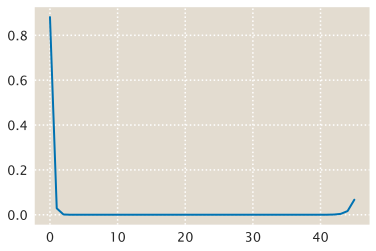

In [16]:
Pmp = MaxEnt_joint_dist(popt.x, products)
Pmp.shape
plt.plot(mRNA_space, Pmp.sum(axis=1))

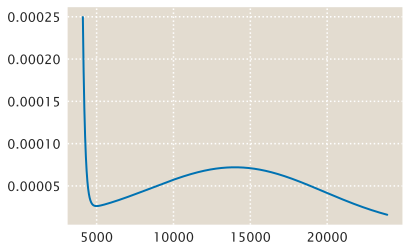

In [434]:
plt.plot(protein_space, Pmp.sum(axis=0))

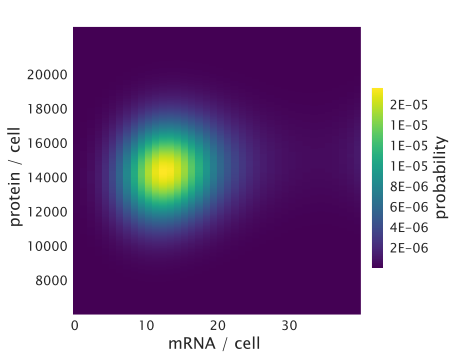

In [424]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot something in the range to keep the axis of this plot
ax.plot([mRNA_space.min(), mRNA_space.max()],
        [protein_space.min(), protein_space.max()])

# Reduce the margins so that it is only the plotting area we desire
ax.margins(0)

# Label axis
ax.set_xlabel('mRNA / cell')
ax.set_ylabel('protein / cell')

# Generate a new axis to add the heatmap
ax2 = fig.add_axes([0.12, 0.12, 0.8, 0.8], anchor='NE', zorder=0)

# Plot heatmap in new axis
cax = ax2.matshow(Pmp.T, aspect='auto', cmap='viridis', origin='lower')
# turn off secondary plot axis
ax2.axis('off')

# Generate a colorbar with the concentrations
cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, cax=cbar_ax, format='%.0E')

# Label colorbar
cbar.set_label('probability')
# plt.savefig(figdir + 'MaxEnt_joint_PMF_unreg.pdf', bbox_inches='tight')

In [370]:
constraints = np.array(mRNA_moments + protein_moments + correlations)

# Define exponents
exponents = ([1, 0], [2, 0], [3, 0],
             [0, 1], [0, 2], [0, 3],
             [1, 1], [2, 1], [1, 2])

idx = [0, 1, 2, 3, 4, 5, 7]
constraints = np.array([constraints[x] for x in idx])
exponents = np.array([exponents[x] for x in idx])

mRNA_space = mRNA_space.astype('float')
protein_space = protein_space.astype('float')
mRNA_space[mRNA_space == 0] = 1E-323
protein_space[protein_space == 0] = 1E-323

products = np.zeros([len(constraints), len(mRNA_space), len(protein_space)])
for i, exp in enumerate(exponents):
    products[i, :, :] = product_space(mRNA_space, protein_space, exp)
    
p0 = np.zeros_like(constraints) 
args = (constraints, products)

In [371]:
jac = lambda param, c, p:\
        MaxEnt_jacobian(param, c, p, mRNA_space, 
                        protein_space, exponents)
    
hess = lambda param, c, p:\
        MaxEnt_hessian(param, c, p, mRNA_space, 
                       protein_space, exponents)

In [372]:
popt = scipy.optimize.least_squares(MaxEnt_resid, p0, args=args)
popt.x

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


ValueError: array must not contain infs or NaNs

In [277]:
Pmp = MaxEnt_joint_dist(popt.x, products)
Pmp.shape

(40, 15842)

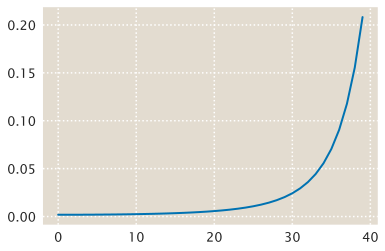

In [278]:
plt.plot(mRNA_space, Pmp.sum(axis=1))

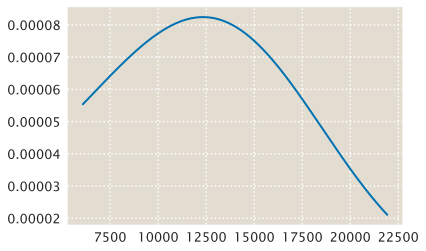

In [273]:
plt.plot(protein_space, Pmp.sum(axis=0))

In [161]:
def MaxEnt_newton_raphson(mRNA, protein, constraints, exponents, 
                          lambda0=None, tol=1E-4, maxiter=1000, 
                          verbose=False, loop_print=25):
    '''
    Implementation of the Newton-Raphson algorithm as defined by Smadbeck &
    Kaznessis, PNAS, 2013 to find the value of the Lagrange Multipliers that
    give the MaxEnt approximation to the joint distribution P(mRNA, protein).
    Parameters
    ----------
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    constraints : array-like.
        Target constraints for the moments in the distribution. This are the
        expected moments of the form <m**x * p**y> that the MaxEnt dist is
        trying to satisfy
    exponents : list. len(constraints)
        A list of the exponents associated with each of the constraints
        Each entry in the list is a array-like. 2x1
            Exponents for the product.
            exponents[0] = mRNA exponent x
            exponents[1] = mRNA exponent y
    lambda0 : array-like. len(constraints). Default None
        Initial guess for the Lagrange multipliers. There should be one
        initial guess for each of the constraints. If not given the algorithm
        assumes zero as the initial guess for all entries.
    tol : float.
        Target tolerance for the stop criteria of the algorithm
    maxiter : int. Default = 1000
        Maximum number of iterations of the algorithm
    verbose : bool. Default = False
        boolean indicating if the information at each iteration should be
        printed
    loop_print : int. Default = 25
        If verbose is True it prints the loop every loop_print loops
    Returns
    -------
    List of Lagrange multipliers that satisfy the distribution.
    '''
    # 1. Initialize array of lambdas
    # Check if not given lambdas initialize them as zeros
    if lambda0 == None:
        lambdas = np.zeros(len(constraints))
    else:
        lambdas = lambda0

    # Check that the number of constraints and given exponents is consistent
    if (len(constraints) != len(exponents)) or \
    (len(constraints) != len(lambdas)):
        raise ValueError('The number of constraints and associated' +\
                            'exponents and inital lambdas must be equal')

    # == Pre-compute products associated with the exponents == #
    # Initialize matrix to save products
    products = np.zeros([len(constraints), len(mRNA), len(protein)])
    # Compute each of the products and store them
    for i, expo in enumerate(exponents):
        products[i, :, :] = product_space(mRNA, protein, expo)
    
    # Initialize loop counter and tolerance
    loop_count = 0
    epsilon = 1
    
    # Loop until either tol or maxiter is satisfied or
    while loop_count < maxiter:
        # 2. Compute probability distribution
        Pmp = MaxEnt_joint_dist(lambdas, products)
        
        # 3. Calculate moments associated with constraints
        maxent_moments = np.array([MaxEnt_joint_moment(mRNA, protein, Pmp, x) \
                                   for x in exponents])
        
        # 4. Compute the ∆moments
        delta_moments = constraints - maxent_moments
        
        # 5. calcualte the 2-norm error
        epsilon = np.dot(delta_moments, delta_moments)
        
        # 6. If tolerance is satisfied break loop
        if epsilon <= tol:
            break
        
        if (verbose) and (loop_count % loop_print == 0):
            print('loop count: ', loop_count)
            print('2-norm error: ', round(epsilon, int(np.log10(tol))))
        # a. Calculate Jacobian Matrix
        # Initialize matrix
        Jacobian = np.zeros([len(constraints), len(constraints)])
        # Loop through exponents computing each entry of the matrix
        for i, expi in enumerate(exponents):
            for j, expj in enumerate(exponents):
                Jacobian[i, j] = - MaxEnt_joint_moment(mRNA, protein, Pmp, 
                                   np.array(expi) + np.array(expj))
        
        # b. Calcualte step size for Lagrange multipliers
        delta_lambdas = np.dot(np.linalg.inv(Jacobian), delta_moments)
        # c. update lambdas
        lambdas += delta_lambdas
        
        # update counter
        loop_count += 1
    print('# loops: ',loop_count)
    
    return lambdas

# Two-state unregulated promoter
---

As an exercise to test the performance of this approximation let's fit the Maximum entropy model to the two-state unregulated promoter model. 

Let's first define the three functions needed to implement the first two moment constraints.

Now let's define the parameters for the *lacUV5* unregulated promoter.

In [7]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1)

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5['rp'] = 1000 * par_UV5['gp']

We can now use the `maxnetropy` package to fit the maximum entropy model.
Let's do it systematically incrementing the number of moments used for the approximation.

In [8]:
# Extract the parameters in order to feed them to the moment functions
m_param = ['kp_on', 'kp_off', 'rm', 'gm']
p_param = ['kp_on', 'kp_off', 'rm', 'gm', 'rp', 'gp']
par_m = [par_UV5.get(x) for x in m_param]
par_p = [par_UV5.get(x) for x in p_param]

# Write down the constraints
# mRNA
mRNA_moments = [chann_cap.first_unreg_m(*par_m),\
             chann_cap.second_unreg_m(*par_m),\
             chann_cap.third_unreg_m(*par_m)]
# Protein
protein_moments = [chann_cap.first_unreg_p(*par_p),\
                chann_cap.second_unreg_p(*par_p),\
                chann_cap.third_unreg_p(*par_p)]
# Cross-correlations
correlations = [chann_cap.mp_unreg_p(*par_p),\
                chann_cap.m2p_unreg_p(*par_p),\
                chann_cap.mp2_unreg_p(*par_p)]

constraints = np.array(mRNA_moments + protein_moments + correlations)

# Define exponents
exponents = ([1, 0], [2, 0], [3, 0],
             [0, 1], [0, 2], [0, 3],
             [1, 1], [2, 1], [1, 2])

In order to define a computationally more efficient sample space we will make use of what we know about the first and second moment. We will define the sample space as mean $\pm $  $Y \times$ standard deviation, where $Y$ is some factor.

Let's define this sample space.

In [10]:
# Extract moments
mRNA_mean = mRNA_moments[0]
mRNA_std = np.sqrt(mRNA_moments[1] - mRNA_mean**2)
protein_mean = protein_moments[0]
protein_std = np.sqrt(protein_moments[1] - protein_mean**2)

# Compute range
std_factor = 4
mRNA_range = [int(x) for x in [mRNA_mean - std_factor * mRNA_std,
              mRNA_mean + std_factor * mRNA_std]]
protein_range = [int(x) for x in [protein_mean - std_factor * protein_std,
                 protein_mean + std_factor * protein_std]]

# Define sample space
mRNA_space = np.arange(*mRNA_range)
protein_space = np.arange(*protein_range)

# Eliminate negative numbers
mRNA_space = mRNA_space[mRNA_space >= 0]
protein_space = protein_space[protein_space >= 0]

Now let's fit the distribution.

In [190]:
constraints = np.array(mRNA_moments)
expo = exponents[0:3]
# lambda_mRNA = MaxEnt_newton_raphson(mRNA_space, protein_space, 
#                                 constraints, expo, tol=1E-5)
# lambda_mRNA

# loops:  586


array([ -7.33635314e-01,   4.45841878e-02,  -7.33132027e-04])

In [25]:
Pmp = MaxEnt_joint_dist(popt, products).sum(axis=1)
Pmp.shape

NameError: name 'expo' is not defined

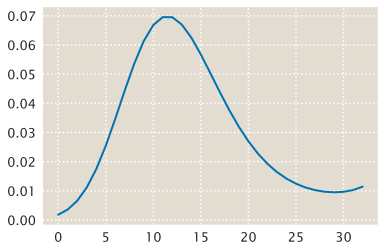

In [192]:
plt.plot(mRNA_space, Pmp)

In [168]:
lambdas = MaxEnt_newton_raphson(mRNA_space, protein_space, 
                                constraints, exponents, verbose=True,
                               loop_print=50)

loop count:  0
2-norm error:  10000.0
loop count:  50
2-norm error:  0.0
loop count:  100
2-norm error:  0.0
# loops:  106


In [ ]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot something in the range to keep the axis of this plot
ax.plot([mRNA_space.min(), mRNA_space.max()],
        [protein_space.min(), protein_space.max()])

# Reduce the margins so that it is only the plotting area we desire
ax.margins(0)

# Label axis
ax.set_xlabel('mRNA / cell')
ax.set_ylabel('protein / cell')

# Generate a new axis to add the heatmap
ax2 = fig.add_axes([0.12, 0.12, 0.8, 0.8], anchor='NE', zorder=0)

# Plot heatmap in new axis
cax = ax2.matshow(Pmp, aspect='auto', cmap='viridis', origin='lower')
# turn off secondary plot axis
ax2.axis('off')

# Generate a colorbar with the concentrations
cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, cax=cbar_ax, format='%.0E')

# Label colorbar
cbar.set_label('probability')
# plt.savefig(figdir + 'MaxEnt_joint_PMF_unreg.pdf', bbox_inches='tight')

In [ ]:
fit_dist = True
if fit_dist:
    # Define the minimum entropy 
    model = MinDivergenceModel(features, samplespace, vectorized=False,
                               verbose=False)
    model.algorithm = 'Powell'
    model.tol = 1E-3
    model.paramstol = 1E-3
    model.maxiter = 500
    model.callingback = True
    # Change the dimensionality of the array
    X = np.reshape(constraints, (1, -1))
    # Fit the model
    model.fit(X)
    # Change dill setting to allow the export of the functions
    dill.settings['recurse'] = True

    # Open file to save functions
    with open(tmpdir + 'two_state_Pmp_maxEnt_II.dill', 'wb') as file:
        dill.dump(model, file)
        dill.dump(mRNA_space, file)
        dill.dump(protein_space, file)

In [ ]:
# Load model and sample space
with open(tmpdir + 'two_state_Pmp_maxEnt_II.dill', 'rb') as file:
    model = dill.load(file)
    mRNA_space = dill.load(file)
    protein_space = dill.load(file)

# Convert probability to 2D matrix
Pmp = model.probdist().reshape(len(mRNA_space), len(protein_space)).T
Pmp.shape

In [ ]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot something in the range to keep the axis of this plot
ax.plot([mRNA_space.min(), mRNA_space.max()],
        [protein_space.min(), protein_space.max()])

# Reduce the margins so that it is only the plotting area we desire
ax.margins(0)

# Label axis
ax.set_xlabel('mRNA / cell')
ax.set_ylabel('protein / cell')

# Generate a new axis to add the heatmap
ax2 = fig.add_axes([0.12, 0.12, 0.8, 0.8], anchor='NE', zorder=0)

# Plot heatmap in new axis
cax = ax2.matshow(Pmp, aspect='auto', cmap='viridis', origin='lower')
# turn off secondary plot axis
ax2.axis('off')

# Generate a colorbar with the concentrations
cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, cax=cbar_ax, format='%.0E')

# Label colorbar
cbar.set_label('probability')
# plt.savefig(figdir + 'MaxEnt_joint_PMF_unreg.pdf', bbox_inches='tight')

---
# Three-state regulated promoter.
---

Let's now define a function that computes the first two moments of the protein distribution as a function of the repressor copy number, repressor-DNA binding energy as well as the inducer concentration.

In [ ]:
def moment_reg_p(moment, C, rep, eRA, 
                 k0=2.7E-3, kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 rp=0.0975, gp=97.53,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5):
    '''
    Computes the mean protein copy number  as a function  of all the 
    parameters that go into the chemical master equation.
    
    Parameters
    ----------
    moment : string.
        Moment to be computed. Options: 'first', 'second' and 'third'.
    C : array-like.
        Concentration at which evaluate the probability.
    rep: float.
        repressor copy number per cell.
    eRA : float.
        Repressor binding energy [kBT]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
        
    Returns
    -------
    protein copy number moment
    '''
    # Convert C into np.array
    C = np.array(C)
    
    # Calculate the repressor on rate including the MWC model
    kr_on = k0 * rep * chann_cap.p_act(C, ka, ki, epsilon)
    # Compute the repressor off-rate based on the on-rate and the binding energy
    kr_off = chann_cap.kr_off_fun(eRA, k0, kp_on, kp_off, Nns)
    
    if moment == 'first':
        return chann_cap.first_reg_p(kr_on, kr_off, kp_on, kp_off,
                                     rm, gm, rp, gp)
    elif moment == 'second':
        return chann_cap.second_reg_p(kr_on, kr_off, kp_on, kp_off,
                                      rm, gm, rp, gp)
    elif moment == 'third':
        return chann_cap.third_reg_p(kr_on, kr_off, kp_on, kp_off,
                                     rm, gm, rp, gp)
    else:
        print('please specify first, second or third moment')

We now define a function that takes all these parameters, along with the necessary elements (sample space, constraints, functions to compute moments) and returns the maximum entropy distribution.

In [ ]:
def maxent_reg_p(constraint_dict, samplespace, C, rep, eRA,
                 k0=2.7E-3, kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 rp=0.0975, gp=97.53,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5, algorithm='Powell',
                 disp=False):
    '''
    Computes the MaxEnt distribution approximation as a function of all the 
    parameters that go into the chemical master equation.
    
    Parameters
    ----------
    constraint_dict : dictionary.
        Dictionary containing the functions to compute the constraints.
        The name of the entries should be the same as the name of the moments,
        for example constraint_dict = {'first' : first}.
    samplespace : array-like.
        Bins to be evaluated in the maximum entropy approach.
    C : array-like.
        Concentrations at which evaluate the probability.
    rep: float.
        repressor copy number per cell.
    eRA : float.
        Repressor binding energy [kBT]
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1] 
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
    algorithm : str.
        Algorithm to be used for the parameter optimization. See
        maxentropy.BaseModel help for a list of the available algorithms.
    disp : bool.
        Boolean indicating if the function should display the concentration
        which is computing at the moment
        
    Returns
    -------
    max_ent_dist : array. shape = len(C) x len(samplespace)
        Maximum Entropy probability distribution of protein for each 
        concentration in C
    '''
    # Initialize matrix to save distributions
    max_ent_dist = np.zeros([len(C), len(samplespace)])
    # Loop through concentrations
    for j, c in enumerate(C):
        if disp:
            print(c)
        # Initialize list to save constraints and moments
        const_fn = []
        const_name = []
        # Extract each constraint function and element into lists
        for key, val in constraint_dict.items():
            const_name.append(key)
            const_fn.append(val)

        # Initialize array to save moment values
        moments = np.zeros(len(const_name))
        # Compute the value of the moments given the constraints
        for i, moment in enumerate(const_name): 
            moments[i] = moment_reg_p(moment, c, rep, eRA, 
                                      k0, kp_on, kp_off, rm, gm, rp, gp,
                                      Nns, ka, ki, epsilon)

        # Define the minimum entropy moel
        model = MinDivergenceModel(const_fn, samplespace, algorithm=algorithm)
        # Change the dimensionality of the moment array
        X = np.reshape(moments, (1, -1))
        # Fit the model
        model.fit(X)
        max_ent_dist[j, :] = model.probdist()
    
    # Return probability distribution
    return max_ent_dist

Let's now try to test the function.

First let's define a dictionary containing all of the necessar parameters for a regulated lacUV5 promoter

In [ ]:
# List the parameters fit for the lacUV5 regulated promoter
par_UV5_reg = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5)

# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par_UV5_reg['k0'] = k0_norm

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5_reg['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5_reg['rp'] = 1000 * par_UV5_reg['gp']

print(par_UV5_reg)

### Two-moment MaxEnt approximation.

Now let's define the necessary variables to compute the MaxEnt distributions for different IPTG concentrations **using only the first two moments** for the approximation.

In [ ]:
# Define constraint dictionary containing the moments
constraint_dict = {'first':first, 'second':second}

# Define concentrations to test
IPTG = [0, 1, 10, 50, 100, 1000] #µM

# Copy parameters and add repressor copy number and binding energy
par = par_UV5_reg.copy()
par['eRA'] = -13.9 #kBT
par['rep'] = 260 #repressors / cell

# Define the sample space
samplespace = np.arange(int(2.5E4))

dist_maxent_reg = maxent_reg_p(constraint_dict, samplespace, IPTG, 
                               algorithm='BFGS',
                               disp=True, **par)

Let's plot both the PMF and CDF together.

In [ ]:
chann_cap.pmf_cdf_plot(samplespace, dist_maxent_reg, 
                       IPTG, color_palette='Blues',
             mean_mark=True, marker_height=8E-4, ylim=[0, 1E-3],
             color_bar=True, cbar_label='[IPTG] µL',
             binstep=100,
             title='O2 - R260', xlabel='protein / cell')

plt.savefig(figdir + 'maxEnt_dist_protein_O2_R260_two.pdf', bbox_inches='tight')

### Three-moment MaxEnt approximation.

Now let's compute this **using three moments** to generate the MaxEnt distribution.

In [ ]:
# Define constraint dictionary containing the moments
constraint_dict = {'first':first, 'second':second, 'third':third}

# Define the sample space
samplespace = np.arange(int(2.5E4))

dist_maxent_reg = maxent_reg_p(constraint_dict, samplespace, IPTG, 
                               algorithm='Powell',
                               disp=True, **par)

In [ ]:
chann_cap.pmf_cdf_plot(samplespace, dist_maxent_reg, 
                       IPTG, color_palette='Blues',
             mean_mark=True, marker_height=8E-4, ylim=[0, 1E-3],
             color_bar=True, cbar_label='[IPTG] µL',
             binstep=25,
             title='O2 - R260', xlabel='protein / cell')

plt.savefig(figdir + 'maxEnt_dist_protein_O2_R260_three.pdf', 
            bbox_inches='tight')

There is a notorious difference only at the low end expression level. Otherwise for high inducer concentrations the distributions look exactly the same.

It seems that the function is working! And now we can generate an input-output matrix $P(p \mid C)$ from which to compute the channel capacity using the Blahut-Arimoto algorithm.

# Computing the channel capacity

Having this input-output function let's use the Blahut-Arimoto algorithm function to compute the channel capacity.

First let's test it with the input-output matrix we generated for the example.

In [ ]:
c, pc, loop_count = chann_cap.channel_capacity(dist_maxent_reg)

print('The channel-capacity is {:.2f} bits'.format(c))

Let's now systematically build the input-output function for different repressor copy numbers and operators

### Comparing two- vs three-moments approximations.

Let's compare the effect of using two- vs. three-moments for the MaxEnt distribution approximation. First we will compute the channel capacity using only the first two moments to infer the distribution.

In [ ]:
# List the parameters fit for the lacUV5 regulated promoter
par_UV5_reg = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5)
# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par_UV5_reg['k0'] = k0_norm

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5_reg['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5_reg['rp'] = 1000 * par_UV5_reg['gp']


# Define constraint dictionary containing the moments
constraint_dict = {'first':first, 'second':second}

# Define the sample space
samplespace = np.arange(int(2.5E4))

# Define experimental concentrations in µM
c = [0, 0.1, 1, 5, 7.5, 10, 25, 50, 75, 100, 250, 500, 1000] # µM

# Define repressor copy numebers
repressors = np.logspace(0, np.log10(2000), 50)
repressors = np.unique(repressors.round(0))

# Define operators and energies
operators = ['O1', 'O2', 'O3', 'Oid']
energies = [-15.3, -13.9, -9.7, -17]
op_dict = dict(zip(operators, energies))
op_dict

Having defined the parameters let's compute the channel capacity for each operator and repressor copy number using a parallelized function.

In [ ]:
compute_channcap = False
if compute_channcap:
    # initialize data frame to save channel capacity computation
    df_channcap = pd.DataFrame(columns=['operator', 'repressor', 'channcap'])
    # loop through operators
    for op in operators:
        print(op)
        # Define function to compute in parallel the channel capacity
        def cc_parallel(r):
            par = par_UV5_reg.copy()
            par['eRA'] = op_dict[op] #kBT
            par['rep'] = r #repressors / cell
            # Build transition matrix
            QpC = maxent_reg_p(constraint_dict, samplespace, c,
                               algorithm='Powell', **par)
            # Compute the channel capacity with the Blahut-Arimoto algorithm
            cc = chann_cap.channel_capacity(QpC, epsilon=1E-3)[0]
            return cc
            # generate a series with the relevant data
        # Run the function in parallel
        ccaps = Parallel(n_jobs=6)(delayed(cc_parallel)(r) for r in repressors)
        # Convert to tidy data frame
        ccaps = pd.DataFrame(ccaps, columns=['channcap'])
        ccaps.loc[:, 'operator'] = pd.Series([op] * len(ccaps))
        ccaps.loc[:, 'repressor'] = pd.Series(repressors)

        df_channcap = pd.concat([df_channcap, ccaps], axis=0)
    df_channcap.to_csv(datadir + 'chann_cap_maxEnt_protein_two_moments.csv',
                       index=False)

---
## Incomplete
*I need to find a solution for the numerical instability of the `scipy.optimize` function that the `maxentropy` package depends on*

---
Now let's do the same using three moments to compute the distribution.

In [ ]:
# Define the sample space
samplespace = np.arange(int(3E4))

# Define constraint dictionary containing the moments
constraint_dict = {'first':first, 'second':second, 'third':third}

In [ ]:
compute_channcap = False
if compute_channcap:
    # initialize data frame to save channel capacity computation
    df_channcap = pd.DataFrame(columns=['operator', 'repressor', 'channcap'])
    # loop through operators
    for op in operators:
        print(op)
        # Define function to compute in parallel the channel capacity
        def cc_parallel(r):
            par = par_UV5_reg.copy()
            par['eRA'] = op_dict[op] #kBT
            par['rep'] = r #repressors / cell
            # Build transition matrix
            QpC = maxent_reg_p(constraint_dict, samplespace, c,
                               algorithm='Powell', **par)
            # Compute the channel capacity with the Blahut-Arimoto algorithm
            cc = chann_cap.channel_capacity(QpC, epsilon=1E-3)[0]
            return cc
            # generate a series with the relevant data
        # Run the function in parallel
        ccaps = Parallel(n_jobs=6)(delayed(cc_parallel)(r) for r in repressors)
        # Convert to tidy data frame
        ccaps = pd.DataFrame(ccaps, columns=['channcap'])
        ccaps.loc[:, 'operator'] = pd.Series([op] * len(ccaps))
        ccaps.loc[:, 'repressor'] = pd.Series(repressors)

        df_channcap = pd.concat([df_channcap, ccaps], axis=0)
    df_channcap.to_csv(datadir + 'chann_cap_maxEnt_protein_three_moments.csv',
                       index=False)

Let's make the repressor vs. channel capacity plot!

In [ ]:
df_channcap_two = pd.read_csv(datadir + \
                              'chann_cap_maxEnt_protein_two_moments.csv',
                              header=0, index_col=None)
df_channcap_three = pd.read_csv(datadir + \
                              'chann_cap_maxEnt_protein_three_moments.csv',
                              header=0, index_col=None)

In [ ]:
# Group by operator
df_group = df_channcap_two.groupby('operator')

# Define colors for each operator
colors = sns.color_palette('colorblind', n_colors=len(df_group))
operators = [op for op, data in df_group]
color_dict = dict(zip(operators, colors))

fig, ax = plt.subplots(1, 1)
# Loop through operators in the two-moment approximation
for group, data in df_group:
    # Plot data
    ax.plot(data.repressor, data.channcap, label=group, 
            color=color_dict[group])
    
# Group by operator
df_group = df_channcap_three.groupby('operator')
# Loop through operators in the three-moment approximation
for group, data in df_group:
    # Plot data
    ax.plot(data.repressor, data.channcap, label='', linestyle='--',
            color=color_dict[group])

ax.set_xlabel('repressor copy number')
ax.set_ylabel('channel capacity (bits)')
ax.set_xscale('log')
first_legend = ax.legend(loc='upper center', title='operator', ncol=4)

# Add secondary label to distinguish two- vs three-moment approximation
# Add the legend manually to the current Axes.
ax2 = ax.add_artist(first_legend)

# "plot" a solid and a dashed line for the legend
line1, = plt.plot([], [], color='black', label='two')
line2, = ax.plot([], [], color='black', linestyle='--', label='three')
# Create another legend.
plt.legend(handles=[line1, line2], loc='lower center', frameon=False,
           title='# moments')

# Save figure.
plt.savefig(figdir + 'repressor_vs_channcap_protein.pdf', bbox_inches='tight')

There is a numerical instability native to `scipy.optimize` that I can't get around when using all three moments. So for now I'll leave this behind and focus on the predictions made witht the two-moment approximation.

---

In [ ]:
df_group = df_channcap_two.groupby('operator')

fig, ax = plt.subplots(1, 1)
for group, data in df_group:
    ax.plot(data.repressor, data.channcap, label=group)

ax.set_xlabel('repressor copy number')
ax.set_ylabel('channel capacity (bits)')
ax.set_xscale('log')
ax.legend(loc=0, title='operator')
plt.savefig(figdir + 'repressor_vs_channcap_protein.pdf', bbox_inches='tight')

## Comparing predictions with experimental data.

Let's import the experimental data we have collected so far and compare it with the theory we have.

For the experimental data since we do not have a correspondence between arbitrary fluorescent units and molecule count we used different bins for the data and computed the channel capacity at each of this bins. Empirically we see that around
$10^2$ bins it gives the right result, so we will be using this bin number as our best estimate for the experimental data.

First let's look at the files that contain the channel capacity experimental estimation.

In [ ]:
# Define directory where data is stored
expdir = '../../data/csv_channcap_bootstrap/'

# List files with the bootstrap sampling of the
files = glob.glob(expdir + '*channcap_bootstrap.csv')
files[0:3]

Let's systematically read each of the files, extract the data from the bin number closest to **100** and compute the channel capacity estimate for this bin number.

But first let's define a couple of dictionaries to map from RBS name to repressor co py number and from operator yo binding energy.

In [ ]:
# Define dictionaries to map operator to binding energy and rbs to rep copy 
op_dict = dict(zip(['O1', 'O2', 'O3', 'Oid'], [-15.3, -13.9, -9.7, -17]))
rbs_dict = dict(zip(['HG104', 'RBS1147', 'RBS446', 'RBS1027', 'RBS1', 'RBS1L'],
                    [22, 60, 124, 260, 1220, 1740]))

Now let's save the data in a tidy `DataFrame`.

In [ ]:
# Define index of entries to save
index = ['date', 'bins', 'operator', 'rbs', 
         'binding energy', 'repressors', 'channcap']
# Initialize DataFrame to save information
df_cc_exp = pd.DataFrame(columns=index)

# Define bin number to extract
bin_target = 300

# Loop through files
for f in files:
    # Split file name to extract info
    str_split = f.replace(expdir, '').split('_')
    # Extract date, operator and rbs info
    date, op, rbs = str_split[0:3]
    # Map the binding energy and repressor copy number
    eRA, rep = op_dict[op], rbs_dict[rbs]
    
    # Read file
    df_cc_bs = pd.read_csv(f, header=0)

    # Select df_cc_bs closest to desired number of bins
    # Find the index of the min df_cc_bs
    bin_idx = (np.abs(df_cc_bs['bins'] - bin_target)).idxmin()
    # Choose the bind number
    bin_num = df_cc_bs.iloc[bin_idx]['bins']

    # Keep only df_cc_bs with this bin number
    df_cc_bs = df_cc_bs[df_cc_bs['bins'] == bin_num]

    # Extrapolate to N -> oo
    x = 1 / df_cc_bs.samp_size
    y = df_cc_bs.channcap_bs
    # Perform linear regression
    lin_reg = np.polyfit(x, y, deg=1)
    # Extract intercept to find channel capacity estimate
    cc = lin_reg[1]

    # Compile info into a pandas series to append it to the DataFrame
    series = pd.Series([date, bin_num, op, rbs, eRA, rep, cc],
                       index=index)
    # Append to DataFrame
    df_cc_exp = df_cc_exp.append(series, ignore_index=True)

df_cc_exp.head()

Having extracted the data let's plot it on top of the predictions!

In [ ]:
# Group data by operator
df_group = df_channcap_two.groupby('operator')

# Define colors for each operator
operators = df_channcap_two['operator'].unique()
colors = sns.color_palette('colorblind', n_colors=len(operators))
op_col_dict = dict(zip(operators, colors))

fig, ax = plt.subplots(1, 1)
for group, data in df_group:
    ax.plot(data.repressor, data.channcap, label=group, color=op_col_dict[group])
    # Plot data from operator
    ax.plot(df_cc_exp[df_cc_exp['operator'] == group]['repressors'], 
            df_cc_exp[df_cc_exp['operator'] == group]['channcap'], 
            lw=0, marker='o', color=op_col_dict[group], label='')

# Label plot
ax.set_xlabel('repressor copy number')
ax.set_ylabel('channel capacity (bits)')
ax.set_xscale('log')
ax.legend(loc=0, title='operator')
plt.savefig(figdir + 'theory_vs_data_channcap_protein.pdf', bbox_inches='tight')

# Exploring systematic overestimate of the channel capacity.

An interesting general trend when comparing the experimental vs theoretical channel capacity is that it seems as if the predictions systematically overestimate the the channel capacity.

The reasons I can think of for this happening (in order of how likely each of them is) are:
1. Since we are measuring with the microscope, the instrument itself increases the noise in the measurements. As a consequence we always end up measuring a lower channel capacity than the one we would obtain by directly counting the number of proteins per cell.
2. Things such as the variability in number of repressors (copy number and active number of repressors) and RNAP copy number would reduce the predicted channel capacity.
3. The parameters ($k_0$ and/or $r_p$) since are not directly known or inferred from our own self-consistent data are affecting the predictions.
4. The non-linearity of the camera chip is affecting the measurements.

The third of these causes is easy to address. For a particular operator, binding energy and repressor copy number let's systematically change the parameters and see how they affect the predicted channel capacity prediction.

Let's start by defining the parameters.

In [ ]:
# List the parameters fit for the lacUV5 regulated promoter
par_UV5_reg = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5)
# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par_UV5_reg['k0'] = k0_norm

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5_reg['gp'] = gp

# Define constraint dictionary containing the moments
constraint_dict = {'first':first, 'second':second}

# Define experimental concentrations in µM
c = np.array([0, 0.1, 1, 5, 7.5, 10, 25, 50, 75, 100, 250, 500, 1000]) # µM

In [ ]:
# Set parameters to be used
par = par_UV5_reg.copy()
par['eRA'] = -13.9 #kBT
par['rep'] = 260 #repressors / cell
par['rp'] = 1000 * par['gp']

# Define concentrations to test
c = [0, 1, 10, 50, 100, 1000] #µM

# Find a proxy for the mean protein copy number
mean_p = moment_reg_p('first', 5000, **par)
# Define sample depending on the current value of rp
samplespace = np.arange(0, int(2 * mean_p))

# Build transition matrix
QpC = maxent_reg_p(constraint_dict, samplespace, c,
                   algorithm='Powell', disp=True, **par)

Now let's define the range of parameter variability for $r_p$ and let's compute the channel capacity for each of these values

In [ ]:
# Define array of rp values to explore
rp_array = np.logspace(1, 4, 18)

compute_channcap = False
if compute_channcap:
    # Define function to compute in parallel the channel capacity
    def cc_parallel(rp):
        # Set parameters to be used
        par = par_UV5_reg.copy()
        par['eRA'] = -13.9 #kBT
        par['rep'] = 260 #repressors / cell
        par['rp'] = rp * par['gp']

        # Find a proxy for the mean protein copy number
        mean_p = moment_reg_p('first', 5000, **par)
        # Define sample depending on the current value of rp
        samplespace = np.arange(0, int(2 * mean_p))

        # Build transition matrix
        QpC = maxent_reg_p(constraint_dict, samplespace, c,
                           algorithm='Powell', **par)
        # Compute the channel capacity with the Blahut-Arimoto algorithm
        cc = chann_cap.channel_capacity(QpC, epsilon=1E-3)[0]
        return cc
        # generate a series with the relevant data
    # Run the function in parallel
    ccaps_rp = Parallel(n_jobs=6)(delayed(cc_parallel)(rp) for rp in rp_array)
    df_rp = pd.DataFrame(np.vstack([rp_array, ccaps_rp]).T, 
                     columns=['rp_gp', 'channcap'])
    df_rp.to_csv('../../data/csv_maxEnt_dist/channcap_rp.csv',
                       index=False)

Let's now plot the channel capacity as a function of this parameter.

In [ ]:
# df_rp = pd.read_csv(datadir + 'channcap_rp.csv', header=0, index_col=None)

# Plot predictions
plt.plot(df_rp['rp_gp'], df_rp['channcap'])

# Label plot
plt.xlabel(r'$\left\langle \right.$protein$\left. \right\rangle$ / mRNA ' + \
           '($r_p / \gamma_p$)')
plt.ylabel('channel capacity (bits)')
plt.xscale('log')
plt.savefig(figdir + 'rp_vs_channcap_protein.pdf')

This is definitely not the determining variable. We can see that from the $10^2$ to the $10^4$ range the result is effectively the same. And even when going down to $10^1$ the difference is less than 0.1 bits.

# To be continued...